In [243]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt


In [244]:
DATA_DIR = 'data'
SIM_THRESHOLD = 0.5 # similarity threshold for template matching. Can be adapted.

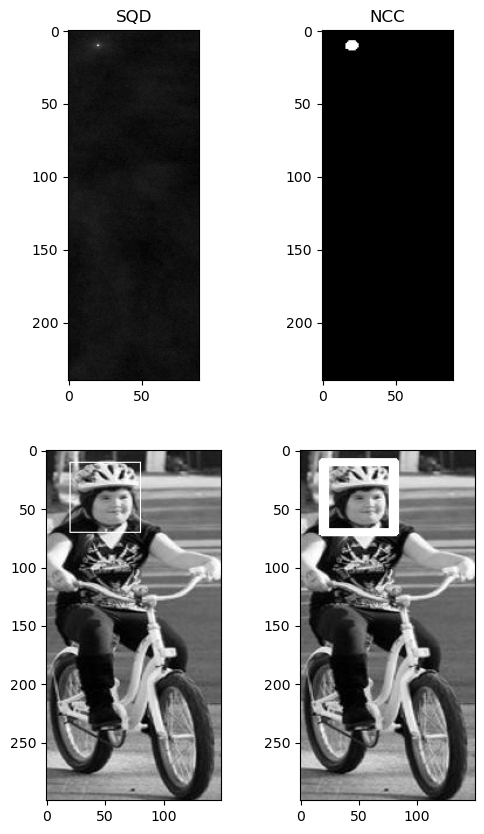

In [245]:
# implement the sum square difference (SQD) similarity 
def calc_sum_square_difference(image, template):
    k, l = template.shape
    output = np.zeros([image.shape[0]-k, image.shape[1]-l])

    for n in range(image.shape[0] - l ):
        for m in range(image.shape[1] - k ):
            output[n][m] = np.sum(np.subtract(template, image[n:n+l, m:m+k])**2)
    
    return output

       
# implement the normalized cross correlation (NCC) similarity 
# Weirdly splitting this function to have less work in Task 3 :)
def calc_normalized_cross_correlation_at_pos(image, template, m,n):
    # DEBUG: print("Pos:",m,n)
    k, l = template.shape
    tmp = image[m:m+k, n:n+l]
    _mean_image_patch = (np.full((k,l), np.mean(tmp)))

    # Calculate the mean of template and create Array with it
    _mean_template = (np.full((k,l), np.mean(template)))
    _template = np.subtract(template, _mean_template)
    _image = np.subtract(tmp, _mean_image_patch)


    top = np.sum(_template * _image)
    bot = (np.sum(_template**2) * np.sum(_image**2)) ** 0.5

    return round(top / bot)

def calc_normalized_cross_correlation(image, template):
    k, l = template.shape
    output = np.zeros([image.shape[0]-k, image.shape[1]-l])

    for m in range(image.shape[0] - k -1):
        for n in range(image.shape[1] - l -1):
            output[m][n] = calc_normalized_cross_correlation_at_pos(image, template, m,n)
    
    return output

#draw rectanges on the input image in regions where the similarity is larger than SIM_THRESHOLD
def draw_rectangles(input_im, similarity_im, size=(60,60)):
    output = input_im.copy()
    for x in range(similarity_im.shape[0]):
        for y in range(similarity_im.shape[1]):
            if(similarity_im[x][y] > SIM_THRESHOLD):
                cv2.rectangle(output, (y, x), (y+size[0], x+size[1]), (255,0,0), 1)
    
    return output

#Template matching using single-scale
def task2(input_im_file, template_im_file):
    full_path_im = os.path.join(DATA_DIR, input_im_file)
    full_path_template = os.path.join(DATA_DIR, template_im_file)
    in_im = cv2.imread(full_path_im, cv2.IMREAD_GRAYSCALE)
    template = cv2.imread(full_path_template, cv2.IMREAD_GRAYSCALE)
    result_sqd = calc_sum_square_difference(in_im, template)
    result_sqd = 1 - result_sqd / np.amax(result_sqd)

    result_ncc = calc_normalized_cross_correlation(in_im, template)
    result_ncc = result_ncc / np.amax(result_ncc)


    #draw rectanges at matching regions
    vis_sqd = draw_rectangles(in_im, result_sqd)
    vis_ncc = draw_rectangles(in_im, result_ncc)

    _, ax = plt.subplots(2, 2, figsize=(6, 10))
    ax[0,0].set_title("SQD")
    ax[0,0].imshow(result_sqd, cmap="gray", norm=None)
    ax[0,1].set_title("NCC")
    ax[0,1].imshow(result_ncc, cmap="gray", norm=None)
    ax[1,0].imshow(vis_sqd, cmap="gray", norm=None)
    ax[1,1].imshow(vis_ncc, cmap="gray", norm=None)


task2('RidingBike.jpeg', 'RidingBikeTemplate.jpeg')

# (3) Template matching multi-scale
In this task, we will build the Gaussian pyramid to make template matching work at different resolutions. Read the image `DogGray.jpeg` and the template `DogTemplate.jpeg`

- Build a **5 level Gaussian pyramid** by downsampling put image yourself.
- Now create a 5 level Gaussian pyramid using `cv2.pyrDown`. Compare it with your implementation by printing the mean absolute difference at each level.
- Perform template matching by using your implementation of normalized cross correlation. **Report the time** taken by this method.
- **Show the template matching** using normalized cross correlation **at the different Pyramid levels** of both the template and input images (you can use the pyramid obtained by pyrDown).
- As you observed, implementing template matching naively is not efficient. Now we will rely on the pyramid technique while constraining the search space in order to make it faster. Follow the procedure described in the lecture slides: search only in regions with high similarity in the previous pyramid level. **Compare the times taken by this method and the naive implementation**.
- **Visualise** the template matching results.

In [246]:
def stepPyramidDown(im):
    image = cv2.GaussianBlur(im, (5,5), 0)
    return image[::2,::2]

def pyramidTemplateMatching(imgs, templates):
    # Find matching areas in highest layer (smallest image)
    img = imgs[-1]
    temp = templates[-1]
    res = calc_normalized_cross_correlation(img, temp)
    # Get all matching locations; multiply coordinates with 2 for next bigger layer
    pos = np.argwhere(res>SIM_THRESHOLD)
    # DEBUG: print(pos)
    pos = pos*2

    # Go trough rest of layers and apply same procedure
    for i in range(len(imgs)-1)[::-1]:
        # DEBUG: print(pos)
        nexpos = []
        for x,y in pos:
            img = imgs[i]
            temp = templates[i]
            res = calc_normalized_cross_correlation_at_pos(img, temp, x, y)
            if(res > SIM_THRESHOLD):
                nexpos.append((x*2,y*2))

        pos = nexpos

    return pos

In [247]:
# task3('DogGray.jpeg', 'DogTemplate.jpeg')
input_im_file = 'DogGray.jpeg'
template_im_file = 'DogTemplate.jpeg'

full_path_im = os.path.join(DATA_DIR, input_im_file)
full_path_template = os.path.join(DATA_DIR, template_im_file)
in_im = cv2.imread(full_path_im, cv2.IMREAD_GRAYSCALE)
template = cv2.imread(full_path_template, cv2.IMREAD_GRAYSCALE)

# Prepare Template Pyramid for later use
template_pyramid = []
template_pyramid.append(template.copy())
for i in range(4):
    template_pyramid.append(stepPyramidDown(template_pyramid[i]))

In [248]:
# Build a 5 level Gaussian pyramid by downsampling the input image
print("# Creating self implemented pyramid")
self_pyramid = []
self_pyramid.append(in_im.copy())
for i in range(4):
    self_pyramid.append(stepPyramidDown(self_pyramid[i]))


# Use cv2.pyrDown() and compare with self implemented
print("\n# Use cv2.pyrDown() and compare with self implemented")
cv_pyramid = []
cv_pyramid.append(in_im.copy())
for i in range(4):
    cv_pyramid.append(cv2.pyrDown(cv_pyramid[i]))
    print("Mean difference on level",i+1,"is:", np.mean(np.subtract(self_pyramid[i], cv_pyramid[i])))

# Creating self implemented pyramid

# Use cv2.pyrDown() and compare with self implemented
Mean difference on level 1 is: 0.0
Mean difference on level 2 is: 0.0
Mean difference on level 3 is: 0.0
Mean difference on level 4 is: 0.0



# Perform template matching by using your implementation of normalized cross correlation
> time taken to perform NCC in seconds: 24.09350085258484

# template matching using normalized cross correlation at different Pyramid levels


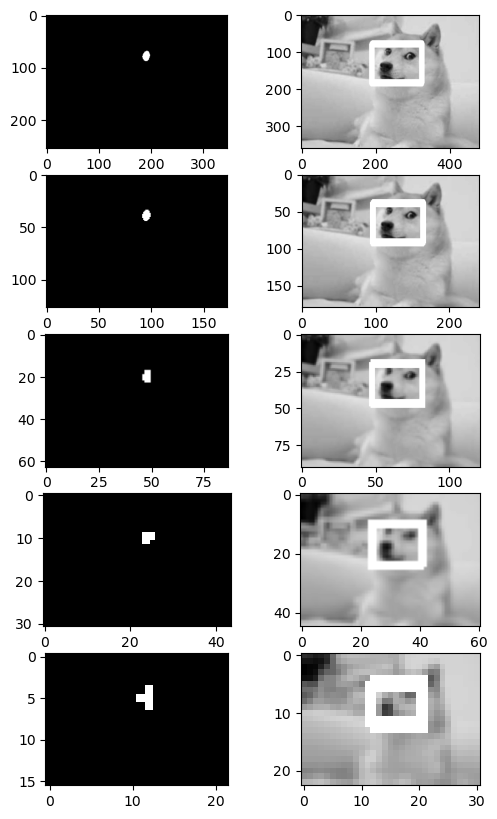

In [249]:
print("\n# Perform template matching by using your implementation of normalized cross correlation")
start_time = time.time()
some_not_that_useless_result = calc_normalized_cross_correlation(in_im, template)
end_time = time.time()
print('> time taken to perform NCC in seconds:', end_time-start_time) # about 20s on my machine

# template matching using normalized cross correlation
print("\n# template matching using normalized cross correlation at different Pyramid levels")


_, ax = plt.subplots(5, 2, figsize=(6, 10))
ax[0,0].imshow(some_not_that_useless_result, cmap="gray", norm=None)
ax[0,1].imshow(draw_rectangles(in_im, some_not_that_useless_result, (template.shape[::-1])), cmap="gray", norm=None)

for i in range(4):
    tmp = calc_normalized_cross_correlation(self_pyramid[i+1], template_pyramid[i+1])
    ax[i+1,0].imshow(tmp, cmap="gray", norm=None)
    ax[i+1,1].imshow(draw_rectangles(self_pyramid[i+1], tmp, (template_pyramid[i+1].shape[::-1])), cmap="gray", norm=None)


In [250]:
print("# Using the method described in the lecture to search smarter, not harder")
start_time = time.time()
pos = pyramidTemplateMatching(self_pyramid, template_pyramid)
end_time = time.time()
print("> Wow! This only less than a second, to be exact:", (end_time-start_time), "meaning, this is a lot faster!")

doggy_coppy = in_im.copy()
for x,y in pos: 
    x = int(x/2)
    y = int(y/2)
    print("Found Doggy Face at:",x,y)
    cv2.rectangle(doggy_coppy, (y,x), (y+template.shape[1], x+template.shape[0]), (255,0,0), 2) # (I hate Index-swapping-errors!)

plt.imshow(doggy_coppy, cmap="gray")

# Using the method described in the lecture to search smarter, not harder
> Wow! This only less than a second, to be exact: 0.023502349853515625 meaning, this is a lot faster!
Found Doggy Face at: 80 192
